In [1]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat, savemat
from itertools import combinations
from tools import url_to_image_id_map_helper
url_to_image_id_map = url_to_image_id_map_helper()

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# expr = 'birds'
# expr = 'dog3_non_random_from_scratch'
# expr = 'dog3_non_random_with_init'
expr = 'dog3_random_with_init'

In [3]:
n = 473 if 'dog' in expr else 125
if 'dog' in expr:
    ground_truth = loadmat('../mat/dogs3_ground_truth.mat')['ground_truth'][0]
else:
    ground_truth = loadmat('../mat/birds20_ground_truth.mat')['ground_truth'][0]

In [4]:
filename = f'./results/{expr}_worker.json'

In [5]:
existed_pairs = {}
existed_pairs_sorted = {}

In [6]:
with open(filename, 'r') as fp:
    data = json.load(fp)

In [7]:
for worker_data in data:
    for question in worker_data['result']:
        left_id = url_to_image_id_map[question['pair']['left']]
        right_id = url_to_image_id_map[question['pair']['right']]

        worker_answer = question['classification']
        true_answer = 1 if ground_truth[left_id] == ground_truth[right_id] else 0

        pair = (left_id, right_id)
        sorted_pair = tuple(sorted(pair))

        if pair in existed_pairs:
            existed_pairs[pair][1] += 1
        else:
            existed_pairs[pair] = [0, 1]

        if sorted_pair in existed_pairs_sorted:
            existed_pairs_sorted[sorted_pair][1] += 1
        else:
            existed_pairs_sorted[sorted_pair] = [0, 1]
        
        if worker_answer != true_answer:
            existed_pairs[pair][0] += 1
            existed_pairs_sorted[sorted_pair][0] += 1

In [8]:
for k, v, in existed_pairs.items():
    existed_pairs[k] = v[0] / v[1]
for k, v, in existed_pairs_sorted.items():
    existed_pairs_sorted[k] = v[0] / v[1]

In [9]:
pair_error_probabilities = np.array(list(existed_pairs.values()))
# keys are sorted, so (1, 2) and (2, 1) are treated as (1, 2)
pair_error_probabilities_sorted = np.array(list(existed_pairs_sorted.values()))

In [10]:
savemat(f'../mat/pair_error_prob_{expr}', {f'pair_error_prob_{expr}': pair_error_probabilities})
savemat(f'../mat/pair_error_prob_{expr}_sorted', {f'pair_error_prob_{expr}_sorted': pair_error_probabilities})

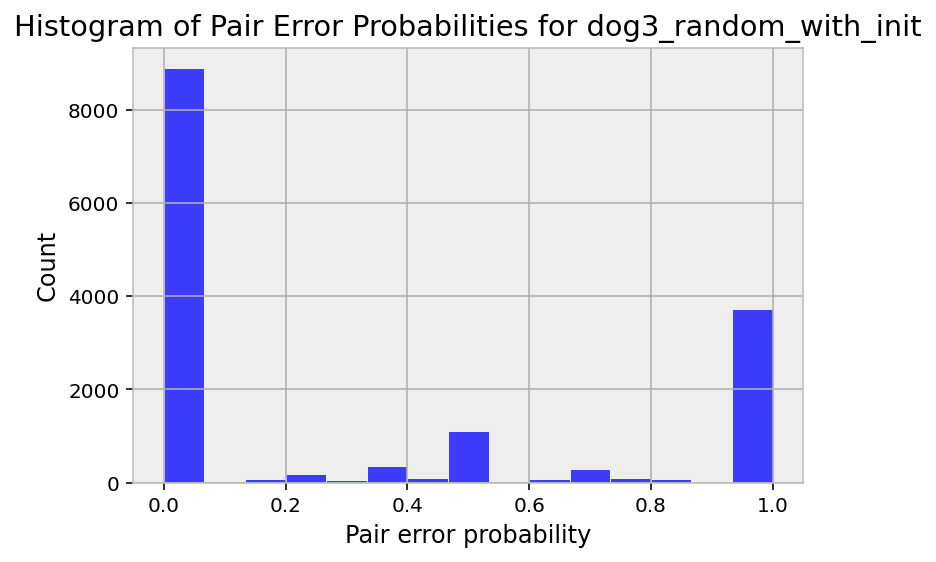

In [11]:
fig = sns.histplot(pair_error_probabilities)
fig.set_title(f'Histogram of Pair Error Probabilities for {expr}')
fig.set_xlabel('Pair error probability')
plt.savefig(f'pair_error_prob_{expr}.png')